<a href="https://colab.research.google.com/github/brunomaxb/churn-prediction-mvp/blob/main/MVP_Churn_OnlineRetailII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Churn Analysis (EDA only) — Online Retail II Dataset**
Name: Bruno Max Barreto Barroso

ID: 4052024001974

Dataset: Online Retail II - https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

# Problem Description

Given the purchase history of each B2B customer in a consumer goods e-commerce platform, we want to estimate the probability of a customer not making any new purchases within the next 6 months (churn). The company could use this score to prioritize retention actions and reduce revenue loss.

## Problem Hypotheses

The hypotheses I considered are as follows:

- Past purchasing patterns are predictive of future behavior.

- There were no drastic changes in the catalog or pricing policies during the analyzed period

- A 6-month window is sufficient to distinguish between seasonal customers and true churn.

## Problem Type

Supervised – binary classification.
- Label = 1 → churn (customer does not purchase for ≥ 6 months after their last observed transaction in the dataset)
- Label = 0 → active.

## Data Selection
- Only customers with at least 3 purchases were considered, to ensure a minimum purchase history.
- Period of data: 2009-12 to 2011-12 (entire available range).
- Excluded returns (rows where Quantity < 0).

## Dataset Attributes

- **InvoiceNo**: unique invoice identifier.
- **StockCode**: product item code.
- **Description**: textual description of the product.
- **Quantity**: number of units sold (integer).
- **InvoiceDate**: date and time of the transaction.
- **UnitPrice**: unit price in British Pounds.
- **CustomerID**: anonymized customer identifier.
- **Country**: customer’s country.

**Derived Attributes** (created during preprocessing):
- Recency, frequency, monetary_value (RFM), days_since_last_purchase, etc.

# Importing the Necessary Libraries and Loading the Dataset

This section consolidates all the library imports required for data analysis, visualization, and preprocessing, as well as the initial loading of the Online Retail II dataset.

In [ ]:
# -----------------------------------------------------------
# Bloco 1 – Imports e configurações de display
# -----------------------------------------------------------
import urllib.request
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import urllib.request

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", context="notebook")

In [ ]:
# -----------------------------------------------------------
# Block 2 – Download and extract dataset from GitHub
# -----------------------------------------------------------

# URL of the zipped dataset hosted on GitHub
URL = "https://github.com/brunomaxb/churn-prediction-mvp/raw/main/data/online_retail_II.csv.zip"
ZIP_PATH = "online_retail_II.csv.zip"
DATA_DIR = "data"

# Ensure target directory exists
os.makedirs(DATA_DIR, exist_ok=True)

# Download the compressed CSV
urllib.request.urlretrieve(URL, ZIP_PATH)

# Extract into data/ (overwrites existing file if present)
with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    zf.extractall(DATA_DIR)

# Optional: clean up the downloaded .zip to save space
try:
    os.remove(ZIP_PATH)
except OSError:
    pass

# Sanity check: list extracted files
os.listdir(DATA_DIR)

['online_retail_II.csv']

In [ ]:
# -----------------------------------------------------------
# Block 3 – Load the 2010–2011 worksheet / CSV
# -----------------------------------------------------------
file_path = "data/online_retail_II.csv"

# Read CSV and parse date column
df_raw = pd.read_csv(file_path, encoding="ISO-8859-1", parse_dates=["InvoiceDate"])

# Keep only the 2010–2011 window
mask = (df_raw["InvoiceDate"] >= "2010-01-01") & (df_raw["InvoiceDate"] < "2012-01-01")
df_raw = df_raw.loc[mask].copy()

# Quick sanity check
print(df_raw["InvoiceDate"].min(), "→", df_raw["InvoiceDate"].max())
df_raw.head(3)

2010-01-04 09:24:00 → 2011-12-09 12:50:00


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0,United Kingdom
45229,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0,United Kingdom
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0,United Kingdom


# Data Analysis

In this stage of Exploratory Data Analysis (EDA) on the Online Retail II dataset, the goal is to understand the distribution, relationships, and characteristics of the variables, which is crucial for the subsequent steps of preprocessing and potential modeling.

## Total and Type of Instances

The Online Retail II dataset contains 1.022.143 records (observations) and 8 columns (features).

In [ ]:
# -----------------------------------------------------------
# Block 4 – Dataset Dimensions and Data Types
# -----------------------------------------------------------
# Total number of records (rows)
print(f"Total records: {len(df_raw)}")
# Data types for each column
print("\nData types by column:")
df_raw.info()

Total records: 1022143

Data types by column:
<class 'pandas.core.frame.DataFrame'>
Index: 1022143 entries, 45228 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1022143 non-null  object        
 1   StockCode    1022143 non-null  object        
 2   Description  1017989 non-null  object        
 3   Quantity     1022143 non-null  int64         
 4   InvoiceDate  1022143 non-null  datetime64[ns]
 5   Price        1022143 non-null  float64       
 6   Customer ID  792604 non-null   float64       
 7   Country      1022143 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 70.2+ MB


In [ ]:
# -----------------------------------------------------------
# Block 5 – Sample Records and Missing Values
# -----------------------------------------------------------

# Display the first rows of the dataset
display(df_raw.head())

# Count of missing values per column
print("\nMissing values per column:")
print(df_raw.isna().sum())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0,United Kingdom
45229,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0,United Kingdom
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0,United Kingdom
45231,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN,United Kingdom
45232,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN,United Kingdom



Missing values per column:
Invoice             0
StockCode           0
Description      4154
Quantity            0
InvoiceDate         0
Price               0
Customer ID    229539
Country             0
dtype: int64


## Descriptive Statistics

Descriptive statistics provide a summary of the numerical features, including mean, standard deviation, minimum, maximum, and quartiles.

In [ ]:
# -----------------------------------------------------------
# Block 6 – Numerical Summary (selected features only)
# -----------------------------------------------------------
numeric_cols = ["Quantity", "Price"]

numeric_summary = (
    df_raw[numeric_cols]
    .describe()          # count, mean, std, min, 25%, 50%, 75%, max
    .T                   # transpose → rows = variables
    .assign(             # add extra metrics
        median=df_raw[numeric_cols].median(),
        mode=df_raw[numeric_cols].mode().iloc[0],
        missing=df_raw[numeric_cols].isna().sum()
    )
)

# Reorder columns for clarity
numeric_summary = numeric_summary[
    ["count", "mean", "std", "min", "25%", "50%", "75%", "max", "median", "mode", "missing"]
]

display(numeric_summary)

,count,mean,std,min,25%,50%,75%,max,median,mode,missing
Quantity,1022143.0,9.967689,176.02889,-80995.00,1.00,3.0,10.00,80995.0,3.0,1.00,0
Price,1022143.0,4.661103,126.17477,-53594.36,1.25,2.1,4.13,38970.0,2.1,1.25,0


**Conclusion**: We identified negative values in the Quantity and Price columns, which are inconsistent with regular purchase transactions. These cases likely represent product returns or data entry errors. Since exploratory analyses should reflect genuine purchasing behavior, we decided to handle these anomalies before proceeding with visualizations and correlation analysis.

In [ ]:
# -----------------------------------------------------------
# Block 7 – Initial Cleaning: Removing returns and invalid rows
# -----------------------------------------------------------
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize common column name variants found in Online Retail II."""
    rename_map = {}
    if "Customer ID" in df.columns and "CustomerID" not in df.columns:
        rename_map["Customer ID"] = "CustomerID"
    if "Price" in df.columns and "UnitPrice" not in df.columns:
        # Keep Price as-is if you prefer; here we standardize to 'Price' used in your EDA
        # If your code usa 'Price', comente a linha abaixo e mantenha 'Price'
        # rename_map["Price"] = "UnitPrice"
        pass
    if "Invoice" in df.columns and "InvoiceNo" not in df.columns:
        rename_map["Invoice"] = "InvoiceNo"
    if rename_map:
        df = df.rename(columns=rename_map)
    return df

def clean_transactions(df: pd.DataFrame,
                       quantity_col: str = "Quantity",
                       price_col: str = "Price",
                       customer_col: str = "CustomerID") -> pd.DataFrame:
    """Return a cleaned transaction DataFrame:
    - normalizes column names (common variants)
    - keeps only rows with Quantity > 0 and Price > 0
    - drops rows without CustomerID
    """
    df = normalize_columns(df).copy()

    # Se o dataset tiver 'UnitPrice' mas você está usando 'Price' no EDA, mapeie aqui:
    if price_col not in df.columns and "UnitPrice" in df.columns:
        price_col = "UnitPrice"

    # Converter tipos úteis (opcional)
    if customer_col in df.columns:
        df[customer_col] = pd.to_numeric(df[customer_col], errors="coerce").astype("Int64")

    # Filtros de consistência
    mask_valid = (df[quantity_col] > 0) & (df[price_col] > 0)
    df_clean = df.loc[mask_valid].copy()

    # Remover registros sem cliente
    if customer_col in df_clean.columns:
        df_clean = df_clean[df_clean[customer_col].notna()].copy()

    return df_clean

def numeric_summary(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Return an ordered numerical summary with extra metrics."""
    out = (
        df[cols]
        .describe()
        .T
        .assign(
            median=df[cols].median(),
            mode=df[cols].mode().iloc[0],
            missing=df[cols].isna().sum()
        )
    )
    # Ordenar colunas para leitura clara
    ordered = ["count", "mean", "std", "min", "25%", "50%", "75%", "max", "median", "mode", "missing"]
    return out[ordered]

In [ ]:
numeric_cols = ["Quantity", "Price"]  # use ["Quantity", "UnitPrice"] se seu arquivo tiver esse nome

df_clean = clean_transactions(df_raw, quantity_col="Quantity", price_col="Price", customer_col="CustomerID")
display(numeric_summary(df_clean, numeric_cols))

,count,mean,std,min,25%,50%,75%,max,median,mode,missing
Quantity,774795.0,13.301601,145.897475,1.000,2.00,5.00,12.00,80995.0,5.00,1.00,0
Price,774795.0,3.206954,29.718313,0.001,1.25,1.95,3.75,10953.5,1.95,1.25,0


### Histogram with Log-Transform of Price

The decision to apply the logarithmic transformation to Price was motivated by the strong skewness of the distribution, identified through descriptive statistics: the mean was much higher than the median, the standard deviation was large, and the presence of extreme values distorted the visualization. After cleaning negative values, these patterns persisted, confirming the need for the transformation to facilitate both analysis and potential modeling.

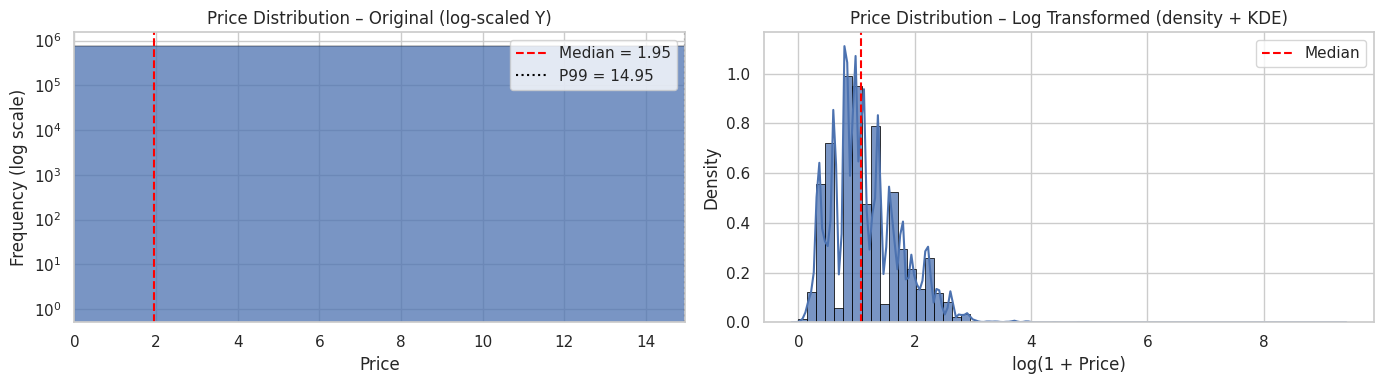

In [ ]:
# -----------------------------------------------------------
# Improved histograms: handle skew and show shape clearly
# -----------------------------------------------------------
p95 = df_clean["Price"].quantile(0.99)   # use 99th to mostrar mais cauda (ajuste se quiser)
med = df_clean["Price"].median()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# (1) Original – escala log no eixo-Y e xlim no p95
sns.histplot(df_clean["Price"], bins=100, ax=axes[0], edgecolor="black")
axes[0].set_title("Price Distribution – Original (log-scaled Y)")
axes[0].set_xlim(0, p95)
axes[0].set_yscale("log")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency (log scale)")
axes[0].axvline(med, linestyle="--", color="red", label=f"Median = {med:.2f}")
axes[0].axvline(p95, linestyle=":", color="black", label=f"P99 = {p95:.2f}")
axes[0].legend(loc="upper right")

# (2) Log-transform – densidade + KDE para ver o shape
log_price = np.log1p(df_clean["Price"])
sns.histplot(log_price, bins=60, stat="density", ax=axes[1], edgecolor="black")
sns.kdeplot(log_price, ax=axes[1], linewidth=1.5)
axes[1].set_title("Price Distribution – Log Transformed (density + KDE)")
axes[1].set_xlabel("log(1 + Price)")
axes[1].set_ylabel("Density")
axes[1].axvline(np.log1p(med), linestyle="--", color="red", label="Median")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


**Conclusion**: The original distribution of Price is heavily right-skewed, with most transactions concentrated below £10 and only a few above £100. The logarithmic transformation (log1p) improved the visualization by compressing the scale and making the values more symmetric, which facilitates subsequent modeling.

### Histograms and KDE: Quantity and Price

The purpose of this analysis is to understand the individual behavior of the most relevant numerical variables in the dataset. The histogram shows how the values are distributed and allows us to identify patterns such as concentration, skewness, and the presence of outliers. The density curve (KDE) complements this visualization with a smooth estimate of the data distribution, making it easier to compare variables and guiding decisions on statistical transformations or data treatments. This information is essential for driving the next steps of preprocessing and modeling.

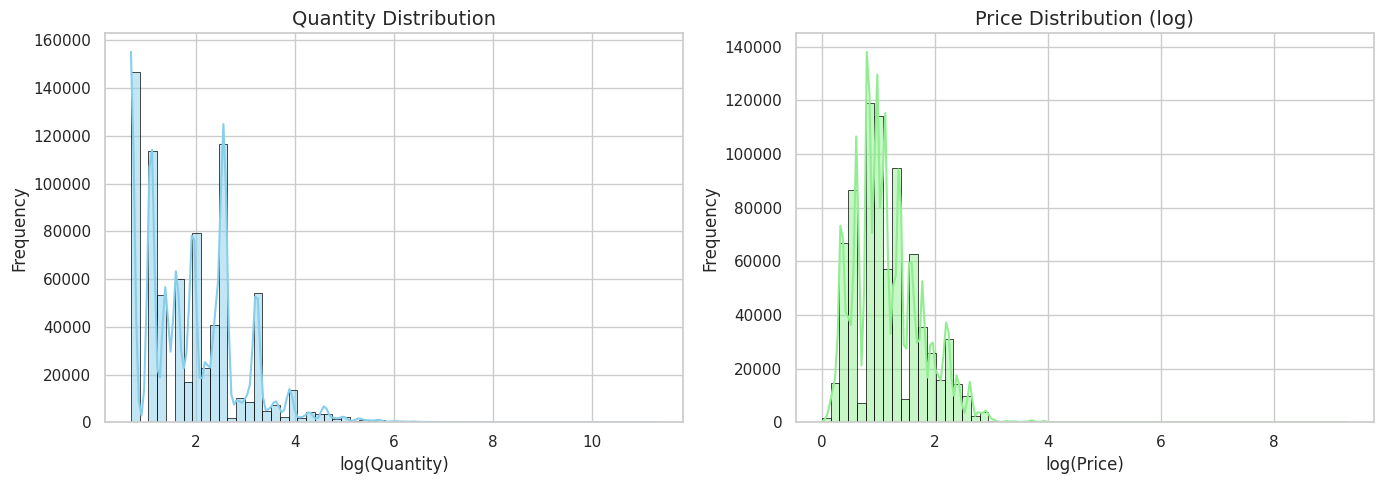

In [ ]:
# -----------------------------------------------------------
# Block 9 – Histograms and KDE for Quantity and Price
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Quantity
sns.histplot(
    np.log1p(df_clean["Quantity"]), bins=60, kde=True,
    ax=axes[0], color="skyblue", edgecolor="black", linewidth=0.5
)
axes[0].set_title("Quantity Distribution", fontsize=14)
axes[0].set_xlabel("log(Quantity)")
axes[0].set_ylabel("Frequency")

# Price
sns.histplot(
    np.log1p(df_clean["Price"]), bins=60, kde=True,
    ax=axes[1], color="lightgreen", edgecolor="black", linewidth=0.5
)
axes[1].set_title("Price Distribution (log)", fontsize=14)
axes[1].set_xlabel("log(Price)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


### Class Distribution (churn vs active)
Before starting modeling, it is essential to check the distribution of the target variable (churn). This makes it possible to assess whether there is a class imbalance, which directly impacts the performance of classification models. If one class (for example, churn) is underrepresented, models may show artificially high performance simply by “always predicting the most frequent class.” The countplot visualization allows for a visual quantification of this balance. If the imbalance is significant, techniques such as class_weight, oversampling with SMOTE, or undersampling can be applied to correct this bias.

In [ ]:
# -----------------------------------------------------------
# Block 10 – Churn definition for engaged customers only
# Rule: customers with >= 3 purchases in the period AND >180 days without buying
# -----------------------------------------------------------

# Handle column name variants
customer_col = "Customer ID" if "Customer ID" in df_clean.columns else "CustomerID"

# Ensure date dtype
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"], errors="coerce")

# Last date observed in the dataset (end of the analysis window)
max_date = df_clean["InvoiceDate"].max()

# Purchases per customer (count and last purchase date)
agg = (
    df_clean.groupby(customer_col, as_index=False)
            .agg(purchase_count=("InvoiceDate", "count"),
                 last_purchase=("InvoiceDate", "max"))
)

# Keep only engaged customers (>= 3 purchases)
df_engaged = agg.loc[agg["purchase_count"] >= 3].copy()

# Days since last purchase
df_engaged["days_since_last_purchase"] = (max_date - df_engaged["last_purchase"]).dt.days

# Churn label: > 180 days without purchasing
df_engaged["churn"] = (df_engaged["days_since_last_purchase"] > 180).astype(int)

# Quick sanity checks
print("Total engaged customers (>=3 purchases):", len(df_engaged))
print("Class proportions (engaged only):")
print(df_engaged["churn"].value_counts(normalize=True).rename({0: "Active", 1: "Churn"}).round(3))


Total engaged customers (>=3 purchases): 5618
Class proportions (engaged only):
churn
Active    0.612
Churn     0.388
Name: proportion, dtype: float64


/tmp/ipython-input-2164890309.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


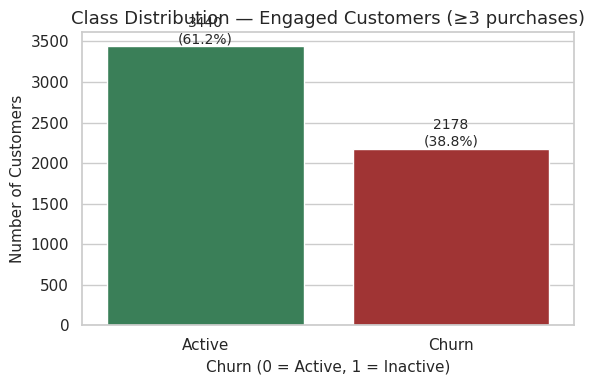

In [ ]:
# -----------------------------------------------------------
# Block 11 – Class distribution (engaged customers) with percentages
# -----------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="churn",
    data=df_engaged,
    order=[0, 1],                    # 0 (Active) first, 1 (Churn) second
    palette=["seagreen", "firebrick"]
)

# Add count and percentage labels on bars
total = len(df_engaged)
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    ax.annotate(f"{count}\n({pct:.1f}%)",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom", fontsize=10)

ax.set_title("Class Distribution — Engaged Customers (≥3 purchases)", fontsize=13)
ax.set_xlabel("Churn (0 = Active, 1 = Inactive)", fontsize=11)
ax.set_ylabel("Number of Customers", fontsize=11)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Active", "Churn"])

plt.tight_layout()
plt.show()


**Conclusion**:
The distribution of engaged customers (≥3 purchases) shows 61.2% active versus 38.8% churned. While there is a moderate class imbalance, it is not extreme. However, this asymmetry is still relevant, as classification models may become biased toward the majority class (active customers).

During the model training phase, it will be important to address this imbalance to avoid overestimating accuracy. Possible actions include:

- Using class weights in algorithms that support them,

- Applying oversampling techniques such as SMOTE,

- Or experimenting with undersampling the majority class.

By correcting this bias, we ensure the model learns to detect churners effectively, which is critical for retention strategies and maximizing customer lifetime value.

### Combined Attribute Analysis (RFM × Churn)

The goal of this stage is to investigate the relationships between variables derived from customer purchasing behavior (such as recency, frequency, and monetary value) and the outcome (churn). This helps to identify distinct behavioral patterns between active and inactive customers and to generate useful insights for modeling. We use:

- Pairplot: to observe the joint distribution and visual correlations between Recency, Frequency, and Monetary.

- Correlation heatmap: to examine linear relationships between numerical variables.

- Recency × Churn boxplot: to check whether churned customers show significantly different behavior in terms of recency.

In [37]:
# -----------------------------------------------------------
# Block 12 – Compute RFM variables per customer
# -----------------------------------------------------------

# Handle common column name variants
customer_col = "Customer ID" if "Customer ID" in df_clean.columns else "CustomerID"
price_col    = "Price"       if "Price"       in df_clean.columns else "UnitPrice"
invoice_col  = "InvoiceNo"   if "InvoiceNo"   in df_clean.columns else (
               "Invoice" if "Invoice" in df_clean.columns else None)

# Reference date for recency (last date in the dataset)
ref_date = df_clean["InvoiceDate"].max()

# Ensure a revenue column exists: Monetary = sum(Quantity * UnitPrice/Price)
df_clean = df_clean.copy()
df_clean["Revenue"] = df_clean["Quantity"] * df_clean[price_col]

# Group by customer and compute RFM:
# - Recency (days since last purchase)
# - Frequency (number of invoices, not line items)
# - Monetary (sum of revenue)
groupby_kwargs = {customer_col: []}  # only for readability below

df_rfm = (
    df_clean.groupby(customer_col).agg(
        Recency=("InvoiceDate", lambda x: (ref_date - x.max()).days),
        Frequency=(invoice_col, "nunique") if invoice_col else ("InvoiceDate", "count"),
        Monetary=("Revenue", "sum")
    )
    .reset_index()
)

# Merge with churn labels (engaged customers ≥ 3 purchases from Blocks 10–11)
# If you want RFM only for engaged customers, keep inner join; for all customers, use how="left".
df_customers = df_rfm.merge(
    df_engaged[[customer_col, "churn"]],
    on=customer_col,
    how="left"
)

# Optional: if your downstream analysis is only for engaged customers, drop rows without churn
# df_customers = df_customers.dropna(subset=["churn"]).copy()
# df_customers["churn"] = df_customers["churn"].astype("Int64")

# Quick sanity check
display(df_customers.head())

,CustomerID,Recency,Frequency,Monetary,churn
0,12346,325,7,77442.96,1.0
1,12347,1,8,5633.32,0.0
2,12348,74,5,2019.40,0.0
3,12349,18,4,4428.69,0.0
4,12350,309,1,334.40,1.0


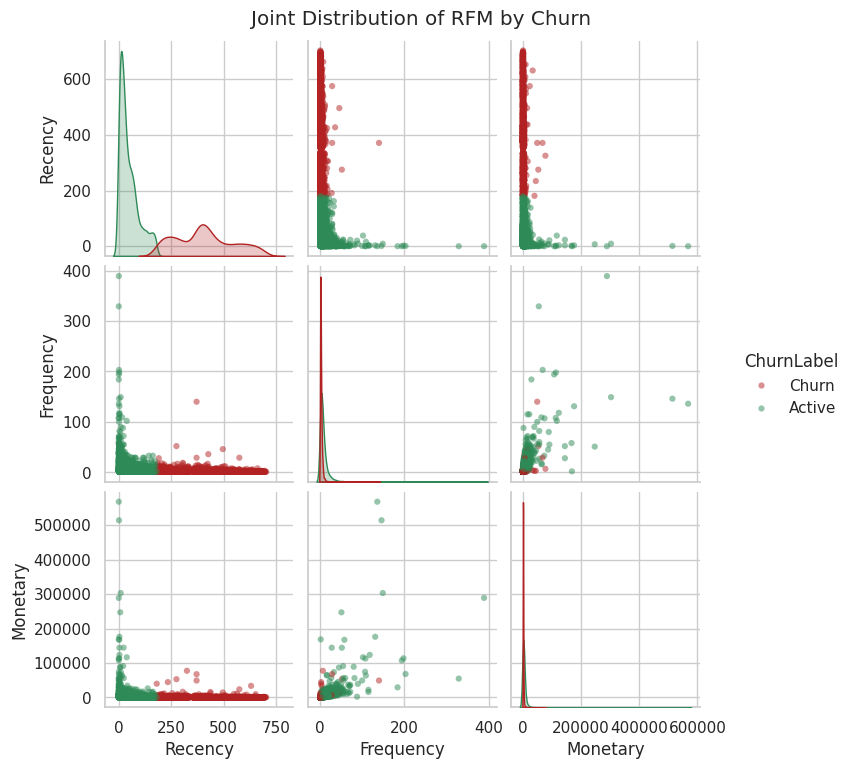

In [40]:
# -----------------------------------------------------------
# Block 13 – Pairplot (RFM) by churn using df_customers
# -----------------------------------------------------------

# Ensure the required columns exist (as created in Block 12)
required_cols = ["Recency", "Frequency", "Monetary", "churn"]
missing = [c for c in required_cols if c not in df_customers.columns]
assert not missing, f"Missing columns in df_customers: {missing}"

# Keep only rows where churn is known (engaged customers) and build a readable label
df_plot = df_customers.dropna(subset=["churn"]).copy()
df_plot["churn"] = df_plot["churn"].astype(int)
df_plot["ChurnLabel"] = df_plot["churn"].map({0: "Active", 1: "Churn"})

# Pairplot of RFM colored by churn
sns.pairplot(
    df_plot,
    vars=["Recency", "Frequency", "Monetary"],
    hue="ChurnLabel",
    diag_kind="kde",
    palette={"Active": "seagreen", "Churn": "firebrick"},
    plot_kws={"alpha": 0.5, "s": 20, "edgecolor": "none"}
)
plt.suptitle("Joint Distribution of RFM by Churn", y=1.02)
plt.show()

**Partial conclusion**:
The plot suggests that churned customers are characterized by high recency, low frequency, and low monetary value, while active customers tend to buy more often, spend more, and have purchased more recently.

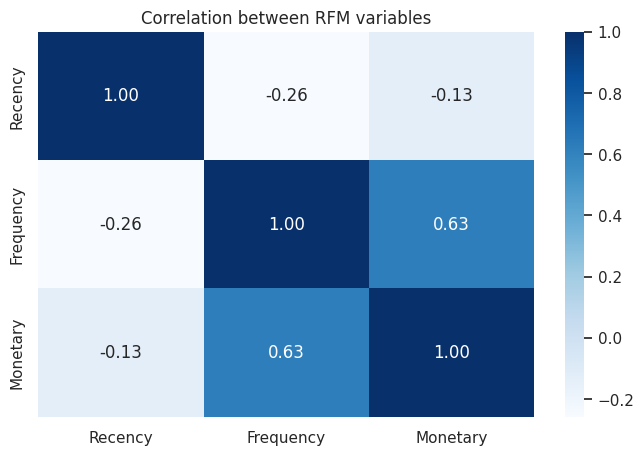

In [41]:
# -----------------------------------------------------------
# Block 14 – Heatmap of correlations
# -----------------------------------------------------------

plt.figure(figsize=(8, 5))
sns.heatmap(
    df_customers[["Recency", "Frequency", "Monetary"]].corr(),
    annot=True,
    cmap="Blues",
    fmt=".2f"
)
plt.title("Correlation between RFM variables")
plt.show()

**Partial Conclusion**:
The heatmap shows a moderate positive correlation between Frequency and Monetary (0.63), which is expected—customers who purchase more frequently also tend to spend more. Recency, on the other hand, has weak negative correlations with both Frequency (–0.26) and Monetary (–0.13), suggesting that the longer the time since the last purchase, the lower the spending and purchase frequency.

# Data Preprocessing

Data preprocessing is a crucial step to prepare the dataset for modeling, ensuring that the data is in the correct format and optimized for algorithm performance.

### Removal and Treatment of Missing Values

In [43]:
# -----------------------------------------------------------
# Block 15 – Removal and Treatment of Missing Values
# -----------------------------------------------------------

# Remove rows with missing Customer ID (if not already done)
df_clean = df_clean[df_clean['CustomerID'].notna()].copy()

# Replace missing values in Description with 'Unknown'
df_clean['Description'] = df_clean['Description'].fillna('Unknown')

# Check if any null values remain in Price (none expected after initial cleaning)
print("Missing values per column:")
print(df_clean.isna().sum())

Missing values per column:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
Revenue        0
dtype: int64


### Removal of Outliers and Discrepancies
- **Remove Quantity < 0**: These rows represent returns, meaning transactions that are the opposite of purchases. Including them would distort key behavioral metrics such as frequency, monetary value, and recency.

- **Winsorize Price at the 99th percentile**: The Price variable contains very high values that deviate significantly from the majority of transactions. To prevent these extreme outliers from dominating the modeling process (especially in linear models), we apply winsorization — a technique that caps extreme values at a chosen threshold without removing them, making the distribution more robust.

In [44]:
# -----------------------------------------------------------
# Block 16 – Outlier removal and winsorization
# -----------------------------------------------------------

# Reinforce filter to keep only purchases (in case it's not 100% guaranteed)
df_clean = df_clean[df_clean["Quantity"] > 0].copy()

# Use the price column detected earlier (Block 12); fallback if needed
price_col = price_col if "price_col" in globals() else (
    "Price" if "Price" in df_clean.columns else "UnitPrice"
)

# Winsorize Price at the 99th percentile (cap extreme high values)
p99 = df_clean[price_col].quantile(0.99)
before = df_clean[price_col].copy()
df_clean[price_col] = df_clean[price_col].clip(upper=p99)

# Optional: report how many values were capped
num_capped = (before > p99).sum()
print(f"Price winsorization: capped {num_capped} values at the 99th percentile ({p99:.2f}).")

# Recompute Revenue after price capping (to keep Monetary consistent)
df_clean["Revenue"] = df_clean["Quantity"] * df_clean[price_col]

Price winsorization: capped 6964 values at the 99th percentile (14.95).


### Adding Derived Features to the Same DataFrame

At this stage, we combine the derived RFM features with the churn label and customer metadata (such as country). This integration ensures that the dataset is consistent and ready for downstream modeling. Additionally, categorical variables (e.g., Country) are transformed into numerical format via one-hot encoding to be used in machine learning algorithms.

In [48]:
# -----------------------------------------------------------
# Block 17 – Adding Derived Features
# -----------------------------------------------------------

# Remove churn column from df_rfm before merging (if it exists)
df_rfm = df_rfm.drop(columns=['churn'], errors='ignore')

# Merge RFM with churn labels
df_model = pd.merge(
    df_rfm,
    df_last_purchase[['CustomerID', 'churn']],
    on='CustomerID',
    how='inner'
)

# Merge df_model with countries
df_model = pd.merge(
    df_model,
    df_clean[['CustomerID', 'Country']],
    on='CustomerID',
    how='left'
)

# Apply one-hot encoding to the Country column
df_model = pd.get_dummies(df_model, columns=['Country'], drop_first=True)

# Quick sample
df_model.sample(15)


,CustomerID,Recency,Frequency,Monetary,churn,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,Country_Czech Republic,Country_Denmark,Country_EIRE,Country_European Community,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Iceland,Country_Israel,Country_Italy,Country_Japan,Country_Korea,Country_Lebanon,Country_Lithuania,Country_Malta,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Poland,Country_Portugal,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_Thailand,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Country_West Indies
492540,16103,6,22,6191.71,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
214324,14096,3,17,65164.79,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
332269,14890,253,3,817.25,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
283356,14572,2,11,5615.18,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
682816,17607,375,1,333.81,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
265800,14474,45,2,1278.08,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
167040,13699,154,2,764.15,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
580308,16795,364,3,2492.39,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
708940,17800,36,9,1199.01,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
90392,13078,2,53,27213.42,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


## Train–Test Split and Normalization

For supervised learning tasks with continuous variables, scaling is crucial to ensure fair contribution of features in models sensitive to scale (e.g., logistic regression, neural networks).

Although StandardScaler is the most common method, it assumes data is approximately normally distributed. In our dataset, however, variables such as Recency, Frequency, and Monetary are highly skewed and contain significant outliers (especially Monetary).

For this reason, we adopt the RobustScaler, which is based on the median and interquartile range (IQR). This approach is more resistant to extreme values, leading to a more stable and realistic scaling process.



In [50]:
# -----------------------------------------------------------
# Block 18 – Train–Test Split and Normalization
# -----------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Define features (X) and target (y)
X = df_model.drop(columns=["churn", "CustomerID"])
y = df_model["churn"]

# Train–test split (70% train, 30% test as default)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Apply RobustScaler to continuous variables only
continuous_vars = ["Recency", "Frequency", "Monetary"]
scaler = RobustScaler()

X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])

# Quick check
print("Scaled features (train sample):")
display(X_train.head())

Scaled features (train sample):


,Recency,Frequency,Monetary,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,Country_Czech Republic,Country_Denmark,Country_EIRE,Country_European Community,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Iceland,Country_Israel,Country_Italy,Country_Japan,Country_Korea,Country_Lebanon,Country_Lithuania,Country_Malta,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Poland,Country_Portugal,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_Thailand,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Country_West Indies
443097,1.878788,-0.05,-0.169767,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
69202,5.681818,-0.50,-0.450243,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
701309,-0.151515,0.25,0.273468,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
683437,7.848485,-0.40,-0.401032,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
127784,0.833333,-0.50,-0.392420,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


/tmp/ipython-input-2065224995.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=axes[0], palette='pastel')
/tmp/ipython-input-2065224995.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=axes[1], palette='pastel')


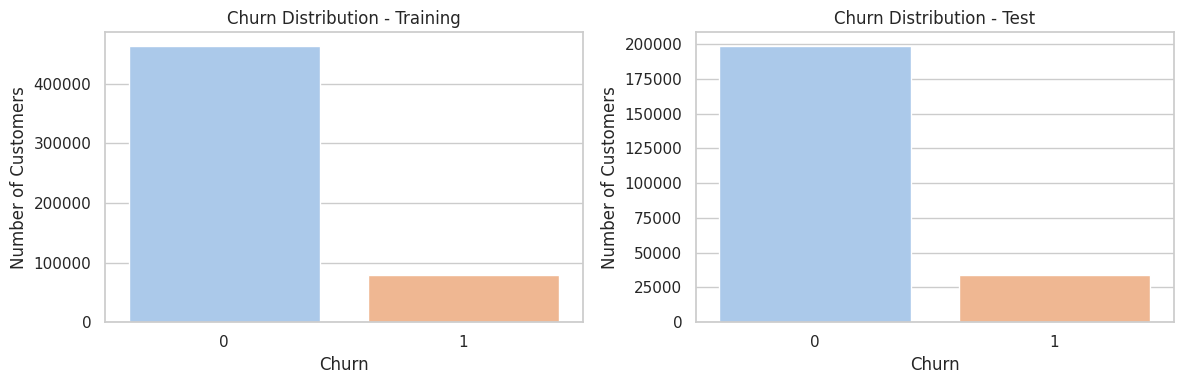

In [51]:
# -----------------------------------------------------------
# Block 19 – Checking Train–Test Balance
# -----------------------------------------------------------

# Side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution in the training set
sns.countplot(x=y_train, ax=axes[0], palette='pastel')
axes[0].set_title('Churn Distribution - Training')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Number of Customers')

# Distribution in the test set
sns.countplot(x=y_test, ax=axes[1], palette='pastel')
axes[1].set_title('Churn Distribution - Test')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

## Analysis of Target Variable Balance

During the analysis of the training and test sets, it was identified that the target variable churn presents a strong imbalance: the majority class (active customers) represents the vast majority of cases, while the minority class (customers who stopped purchasing) makes up only a small fraction of the sample.

This type of imbalance is common in churn prediction problems and can negatively affect model performance, causing algorithms to prioritize the majority class while neglecting their ability to predict the most relevant cases (customers about to leave).

**Strategies to address imbalance:**

- **Class Weights**: Apply class_weight='balanced' in models such as Logistic Regression, SVM, and Random Forest. This adjusts the penalty of misclassifications according to class proportions without altering the data.

- **Oversampling with SMOTE**: Generates synthetic examples of the minority class in the training set, balancing proportions. This is ideal for improving recall without losing data.

- **Undersampling the majority class**: Reduces the number of examples from the majority class. Simple to apply, but may remove useful information.

In [52]:
# -----------------------------------------------------------
# Block 20 – Display Normalized Train and Test Sets
# -----------------------------------------------------------

print("Normalized Training Set (10 rows):")
display(X_train.head(10))

print("Normalized Test Set (10 rows):")
display(X_test.head(10))

Normalized Training Set (10 rows):


,Recency,Frequency,Monetary,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,Country_Czech Republic,Country_Denmark,Country_EIRE,Country_European Community,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Iceland,Country_Israel,Country_Italy,Country_Japan,Country_Korea,Country_Lebanon,Country_Lithuania,Country_Malta,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Poland,Country_Portugal,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_Thailand,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Country_West Indies
443097,1.878788,-0.05,-0.169767,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
69202,5.681818,-0.50,-0.450243,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
701309,-0.151515,0.25,0.273468,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
683437,7.848485,-0.40,-0.401032,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
127784,0.833333,-0.50,-0.392420,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
683374,0.287879,0.00,-0.272888,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
160295,0.696970,-0.45,-0.239431,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
482885,0.257576,-0.40,-0.424257,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
484239,4.363636,-0.50,-0.442864,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
707715,0.000000,-0.20,-0.285627,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


Normalized Test Set (10 rows):


,Recency,Frequency,Monetary,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,Country_Czech Republic,Country_Denmark,Country_EIRE,Country_European Community,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Iceland,Country_Israel,Country_Italy,Country_Japan,Country_Korea,Country_Lebanon,Country_Lithuania,Country_Malta,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Poland,Country_Portugal,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_Thailand,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Country_West Indies
719380,-0.303030,9.60,6.919930,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
320577,-0.287879,0.25,1.130751,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
381964,6.242424,-0.50,-0.388144,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
656308,-0.318182,2.45,5.645146,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
272511,0.636364,-0.50,-0.459922,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
394868,-0.318182,9.15,11.200194,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
163874,-0.287879,1.15,0.877644,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
294534,-0.318182,-0.10,-0.152593,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
538383,0.424242,0.55,0.217117,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
568927,5.651515,-0.50,-0.453132,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


## **Partial Conclusion of Exploratory Analysis and Preprocessing**

The process conducted so far has validated key hypotheses raised at the beginning of the project. The idea that historical behavior patterns could indicate churn propensity proved plausible, especially when observing the relationship between recency, frequency, and monetary value of purchases with customer inactivity status.

It was possible to identify very distinct profiles: customers with high recency (i.e., who purchased a long time ago), low frequency, and low average ticket value are strongly associated with the churn class. On the other hand, active customers maintain regular purchases with higher aggregated values — something evidenced in the RFM distributions and the churn-based separation.

The presence of extreme values and inconsistent records (such as returns with negative values) was addressed through filtering and winsorization, ensuring data integrity without compromising volume. Logarithmic transformation and normalization with RobustScaler allowed us to handle the strong skewness of monetary variables.

The main limitation identified was the strong class imbalance (few inactive customers), which requires careful handling during modeling and evaluation, such as using class_weight='balanced' or oversampling techniques like SMOTE.

## **Business Insight**

Based on the analyses performed, a company could build a churn alert system to prioritize retention actions for customers who:

- have not made a purchase in over 90 days,

- have a history of low purchase volume and value,

- and show a decreasing frequency pattern.

Targeted email marketing campaigns, personalized offers, and follow-ups by sales representatives can be automatically triggered to prevent customer loss and maximize Customer Lifetime Value (CLV).